# Time dependent arrivals via thinning

This notebook provides an overview of how to use the `time_dependent.NSPPThinning` class.  

Thinning is an acceptance-rejection approach to sampling inter-arrival times (IAT) from a time dependent distribution where each time period follows its own exponential distribution.

There are two random variables employed in sampling: an exponential distribution (used to sample IAT) and a uniform distibution (used to accept/reject samples).

All IATs are sampled from an Exponential distribution with the highest arrival rate (most frequent). These arrivals are then rejected (thinned) proportional to the ratio of the current arrival rate to the maximum arrival rate.  The algorithm executes until a sample is accepted.  The IAT returned is the sum of all the IATs that were sampled.

## The thinning algorithm

A NSPP has arrival rate $\lambda(t)$ where $0 \leq t \leq T$

Here $i$ is the arrival number and $\mathcal{T_i}$ is its arrival time.

1. Let $\lambda^* = \max_{0 \leq t \leq T}\lambda(t)$ be the maximum of the arrival rate function and set $t = 0$ and $i=1$

2. Generate $e$ from the exponential distribution with rate $\lambda^*$ and let $t = t + e$ (this is the time of the next entity will arrive)

3. Generate $u$ from the $U(0,1)$ distribution.  If $u \leq \dfrac{\lambda(t)}{\lambda^*}$ then $\mathcal{T_i} =t$ and $i = i + 1$

4. Go to Step 2.

## `sim-tools` imports

In [1]:
from sim_tools.datasets import load_banks_et_al_nspp
from sim_tools.time_dependent import NSPPThinning

In [2]:
# general imports
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Example from Banks et al.

We will illustrate the use of `NSPPThinning` using an example from Banks et al. 

The table below breaks an arrival process down into 60 minutes intervals.


| t(min) | Mean time between arrivals (min) | Arrival Rate $\lambda(t)$ (arrivals/min) |
|:------:|:--------------------------------:|:--------------------------------------:|
|    0   |                15                |                  1/15                  |
|   60   |                12                |                  1/12                  |
|   120  |                 7                |                   1/7                  |
|   180  |                 5                |                   1/5                  |
|   240  |                 8                |                   1/8                  |
|   300  |                10                |                  1/10                  |
|   360  |                15                |                  1/15                  |
|   420  |                20                |                  1/20                  |
|   480  |                20                |                  1/20                  |


> **Interpretation**: In the table above the fastest arrival rate is 1/5 customers per minute or 5 minutes between customer arrivals.

In [3]:
data = load_banks_et_al_nspp()
data

,t,mean_iat,arrival_rate
0,0,15,0.066667
1,60,12,0.083333
2,120,7,0.142857
3,180,5,0.200000
4,240,8,0.125000
5,300,10,0.100000
6,360,15,0.066667
7,420,20,0.050000
8,480,20,0.050000


In [4]:
# create arrivals and set random number seeds
SEED_1 = 42
SEED_2 = 101
arrivals = NSPPThinning(data, SEED_1, SEED_2)

# number of arrivals to simulate
n_arrivals = 15

# run simulation
simulation_time = 0.0
for _ in range(n_arrivals):
    iat = arrivals.sample(simulation_time)
    simulation_time += iat
    print(f'{simulation_time:.2f} Patient arrival (IAT={iat:.2f})')


37.46 Patient arrival (IAT=37.46)
73.02 Patient arrival (IAT=35.56)
89.41 Patient arrival (IAT=16.39)
96.79 Patient arrival (IAT=7.38)
98.37 Patient arrival (IAT=1.58)
104.94 Patient arrival (IAT=6.57)
112.30 Patient arrival (IAT=7.35)
121.49 Patient arrival (IAT=9.19)
127.62 Patient arrival (IAT=6.14)
135.25 Patient arrival (IAT=7.63)
135.64 Patient arrival (IAT=0.39)
141.91 Patient arrival (IAT=6.27)
148.23 Patient arrival (IAT=6.32)
155.26 Patient arrival (IAT=7.04)
158.47 Patient arrival (IAT=3.21)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple

def _generate_nspp_samples(arrival_profile: pd.DataFrame, 
                           run_length: Optional[float] = None, 
                           n_reps: Optional[int] = 1000) -> pd.DataFrame:
    """
    Generate a pandas dataframe that contains multiple replications of
    a non-stationary poisson process for the set arrival profile. 

    This uses the sim-tools NSPPThinning class.

    Useful for validating the the NSPP has been set up correctly and is producing the 
    desired profile for the simulation model.

    On each replication the function counts the number of arrivals during the intervals
    from the arrival profile.  Returns a data frame with reps (rows) and interval arrivals
    (columns)
    
    Parameters:
    -----------
    arrival_profile: pandas.DataFrame
        The arrival profile is a pandas data frame containing 't', 'arrival_rate' and
        'mean_iat' columns. 

    run_length: float, optional (default=None)
        How long should the simulation be run. If none then uses the last value in 't'
        + the interval (assumes equal width intervals) 

    n_reps: int, optional (default=1000)
        The number of replications to run.

    Returns:
    --------
    pd.DataFrame.
    

    """
    # replication results
    replication_results = []

    # multiple replications
    for rep in range(n_reps):

        # method for producing n non-overlapping streams
        seed_sequence = np.random.SeedSequence(rep)
    
        # Generate n high quality child seeds
        seeds = seed_sequence.spawn(2)
        
        # create nspp
        nspp_rng = NSPPThinning(arrival_profile, seeds[0], seeds[1])

        # if no run length has been set....
        if run_length is None:
            run_length = arrival_profile['t'].iloc[len(arrival_profile)-1] + nspp_rng.interval

        # list - each item is an interval in the arrival profile
        interval_samples = [0] * arrival_profile.shape[0]
        simulation_time = 0.0
        while simulation_time < run_length:
            iat = nspp_rng.sample(simulation_time)
            simulation_time += iat

            # data collection: add one to count for hour of the day
            # note list NSPPThinning this assume equal intervals
            interval_of_day = int(simulation_time // nspp_rng.interval) % arrival_profile.shape[0]
            interval_samples[interval_of_day] += 1

        replication_results.append(interval_samples)

   
    # produce summary chart of arrivals per interval
    # format in a dataframe
    df_replications = pd.DataFrame(replication_results)
    df_replications.index = np.arange(1, len(df_replications)+1)
    df_replications.index.name = 'rep'

    return df_replications


def visualise_nspp_via_thinning(arrival_profile: pd.DataFrame, 
                                run_length: Optional[float] = None, 
                                n_reps: Optional[int] = 1000) -> Tuple[plt.Figure, plt.Axes]:
    """Generate a matplotlib chart to visualise a non-stationary poisson process
    for the set arrival profile.

    This uses the sim-tools NSPPThinning class.

    Useful for validating the the NSPP has been set up correctly and is producing the 
    desired profile for the simulation model.

    Parameters:
    ----------
    arrival_profile: pandas.DataFrame
        The arrival profile is a pandas data frame containing 't', 'arrival_rate' and
        'mean_iat' columns. 

    run_length: float, optional (default=None)
        How long should the simulation be run. If none then uses the last value in 't'
        + the interval (assumes equal width intervals) 

    n_reps: int, optional (default=1000)
        The number of replications to run.
    """
    
    # verification of arrival_profile

    # is it a dataframe
    if not isinstance(arrival_profile, pd.DataFrame):
        raise ValueError(f"arrival_profile expected pd.DataFrame "
                         f"got {type(arrival_profile)}")

    # all columns are present
    required_columns = ['t', 'arrival_rate', 'mean_iat']
    for col in required_columns:
        if col not in arrival_profile.columns:
            raise ValueError(f"arrival_profile must contain "
                            f"the following columns: {required_columns}. ")
    

    
    # generate the sample data
    df_interval_results = _generate_nspp_samples(arrival_profile, run_length, n_reps)

    interval_means = df_interval_results.mean(axis=0)
    interval_sd = df_interval_results.std(axis=0) 

    upper = interval_means + interval_sd
    lower = interval_means - interval_sd
    lower[lower < 0] = 0

    # visualise
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot()

    # chart x ticks
    x_values = np.arange(0, arrival_profile.shape[0])

    # plot in this case returns a 2D line plot object
    _ = ax.plot(arrival_profile['t'], interval_means, label="Mean")
    _ = ax.fill_between(arrival_profile['t'], lower, upper, alpha=0.2, label='+-1SD')

    # chart appearance
    _ = ax.legend(loc="best", ncol=3)
    _ = ax.set_ylim(0,)
    _ = ax.set_xlim(0, arrival_profile.shape[0]-1)
    _ = ax.set_ylabel("arrivals")
    _ = ax.set_xlabel("interval (from profile)")
    _ = plt.xticks(arrival_profile['t'])

    return fig, ax



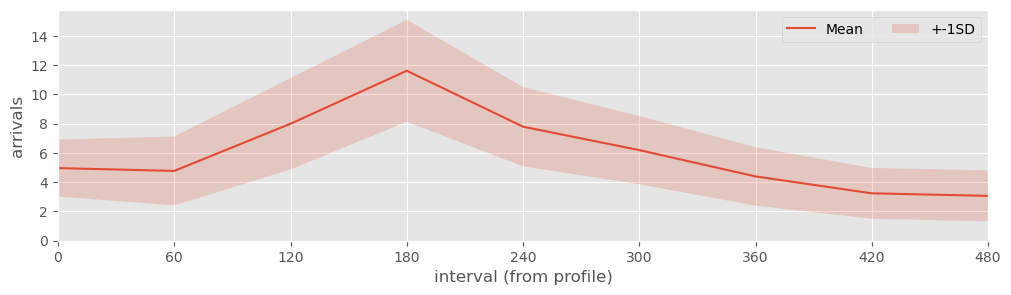

In [6]:
fig, ax = visualise_nspp_via_thinning(data)